[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Barahona_and_Nenes_2007/fig_1.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Barahona_and_Nenes_2007/fig_1.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Barahona_and_Nenes_2007/fig_1.ipynb)

Fig. 1 from [Barahona and Nenes 2007](https://doi.org/10.1029/2007JD008473) using [Lee & Pruppacher 1977](https://doi.org/10.1007/BF00876119) entraining parcel model implemented without dependence on PySDM, and with Pint dimensional analysis checks.

TODO #1433:
- use DimensionalAnalysis context manager to check units only once, and skip units checks for integration
- switch from integration in mass "m" to integration in "ln(r)" or alike ... or to "r" to be closer to the paper
- rho in System: total pressure, but dry air R. (a good approximation)


In [10]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [11]:
import numpy as np
import pint
from matplotlib import pyplot
import scipy
import functools
from scipy import constants
from chempy import Substance
    
si = pint.UnitRegistry()
si.setup_matplotlib()
si.define('fraction = [] = frac')
si.define('percent = 1e-2 frac = pct')

In [12]:
class Constants:
    # polynomial fot to equilibrium vapour pressure wrt water (coefficients from Flatau et al. 1992)
    # doi:10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2
    c_w = (6.115836990e000, 0.444606896e000, 0.143177157e-01, 0.264224321e-03, 0.299291081e-05,
           0.203154182e-07, 0.702620698e-10, 0.379534310e-13, -.321582393e-15)

    T0 = constants.zero_Celsius * si.kelvin

    def __molar_mass(x):
        return Substance.from_formula(x).mass * si.gram / si.mole

    M_a = (
        0.78 * __molar_mass("N2") +
        0.21 * __molar_mass("O2") +
        0.01 * __molar_mass("Ar")
    )
    M_v = __molar_mass("O") + __molar_mass("H") * 2

    R_str = constants.R * si.joule / si.kelvin / si.mole

    R_a = R_str / M_a
    R_v = R_str / M_v

    g = constants.g * si.metre / si.second**2

    l_v = 2.5e6 * si.joule / si.kilogram
    c_p  = 1000 * si.joule / si.kilogram / si.kelvin

    D = 2.26e-5 * si.metre ** 2 / si.second
    K = 2.4e-2 * si.joules / si.metres / si.seconds / si.kelvins
    rho_w = 1 * si.kilogram / si.litre
    sigma_w = 0.072 * si.joule / si.metre**2

    epsilon = R_a/R_v

In [13]:
class Formulae:
    @staticmethod
    def rho(p, R, T):
        return p / (R * T)

    @staticmethod
    def __p_sat(temperature, coefficients, valid_range):
        from numpy.polynomial.polynomial import polyval

        value = polyval(temperature.to(si.celsius).magnitude, coefficients)

        if isinstance(temperature.magnitude, np.ndarray):
            value[np.logical_or(temperature < valid_range[0], temperature > valid_range[1])] = np.nan
        else:
            value = np.nan if not valid_range[0] < temperature <= valid_range[1] else value

        return value * si.hectopascals

    @staticmethod
    def p_eq(T):
        return Formulae.__p_sat(T, Constants.c_w, (Constants.T0-85 * si.kelvin, np.inf * si.kelvin))

    @staticmethod
    def r_dr_dt(S_eq, T, S, rho_eq):
        return (
            (S - S_eq)
            / Constants.rho_w
            / (1 / rho_eq / Constants.D  + Constants.l_v**2 / Constants.K / T**2 / Constants.R_v)
        )
    
    @staticmethod
    def S_eq(drop_radius, kappa, a_dry_3, T):
      return (
          np.exp((2 * Constants.sigma_w / Constants.R_v / T / Constants.rho_w) / drop_radius)
          * (drop_radius**3 - a_dry_3)
          / (drop_radius**3 - a_dry_3 * (1 - kappa))
          ) - 1

    @staticmethod
    def r_cr(kp, a_dry_3, T, sgm): # from https://github.com/open-atmos/PySDM/blob/main/PySDM/physics/hygroscopicity/kappa_koehler.py
        return np.sqrt(3 * kp * a_dry_3 / (2 * sgm / Constants.R_v / T / Constants.rho_w))


In [14]:
class Storage:
    """ state vector representation with each element having its own Pint-compatible
    physical dimension, thus allowing to seamlessly couple Pint and scipy.odeint
    (assumes the last variable extends till the end of the state vector;
    all methods return objects that inherit from `numpy.ndarray` but are additionally
    equipped with .VAR unit-aware setters and getters, allowing both unit-anaware
    whole-array expressions (e.g., `state += dt * deriv`) as well as unit-aware
    operations on state vars (e.g., `state.T = 300 * si.K` or `state.m[:] = ...`) """

    var_units = {
        'p': si.Pa,
        'T': si.K,
        'parcel_radius': si.m,
        'supersaturation': si.dimensionless,
        'w_v': si.dimensionless,
        'n': si.dimensionless,
        'm': si.kg
    }

    der_unit = si.metre

    @staticmethod
    def __make_storage(shape, deriv=False):
        def getter(self, idx, unit):
            return self[idx] * unit

        def setter(self, value, idx, unit):
            self[idx] = (value.to(unit) / unit).magnitude

        properties = {'z_unit': Storage.der_unit}
        for i, key in enumerate(Storage.var_units.keys()):
            kwargs = {
                'unit': Storage.var_units[key] / (Storage.der_unit if deriv else 1),
                'idx': i if i + 1 != len(Storage.var_units) else slice(i, None)
            }
            properties[key] = property(
                functools.partial(getter, **kwargs),
                functools.partial(setter, **kwargs),
            )

        return type("StorageImpl", (np.ndarray,), properties)(shape)

    @staticmethod
    def make_state(n_particles):
        """ returns a newly allocated unit-aware storage of size relevant for `n_particles` simulation """
        return Storage.__make_storage((len(Storage.var_units) - 1 + n_particles,))

    @staticmethod
    def make_deriv(state):
        """ returns a newly allocated unit-aware storage with size of `state` and derivative dimensions """
        return Storage.__make_storage(state.shape, deriv=True)

    @staticmethod
    def view_state(array):
        """ returns a newly allocated unit-aware storage with size and data from unit-unaware `array` """
        storage = Storage.__make_storage(array.shape)
        storage[:] = array[:]
        return storage

In [15]:
class System:
    def __init__(self, *, w, ent_Tdiff, ent_RH, ent_mu, ent_n, r_dry, kappa):
        self.w = w
        self.ent_mu = ent_mu
        self.ent_Tdiff = ent_Tdiff
        self.ent_RH = ent_RH
        self.a_dry_3 = r_dry**3
        self.kappa = kappa
        self.ent_n = ent_n

    def __call__(self, _, state):
        state = Storage.view_state(state)
        deriv = Storage.make_deriv(state)

        #(8)
        deriv.parcel_radius = state.parcel_radius * self.ent_mu / 2 #rough appox of eq.8 to get things working (assumes constant updraft and negligible variability in dry air density)

        rho = Formulae.rho(state.p, Constants.R_a, state.T) 

        # eq. (4)
        deriv.p = -rho * Constants.g

        # eq. (12) PER DROPLET (implied loop)
        drop_radius = (3*state.m/4/np.pi/Constants.rho_w)**(1/3)
        rho_eq = Formulae.p_eq(state.T) / Constants.R_v / state.T
        deriv.m = 4 * np.pi * Constants.rho_w * drop_radius * Formulae.r_dr_dt(
            Formulae.S_eq(drop_radius,self.kappa,self.a_dry_3,state.T), state.T, state.supersaturation, rho_eq
        ) / self.w

        # eq. (5)
        volume = (4/3)*np.pi*state.parcel_radius**3 # new total volume, as we are evolving R with bubble expansion
        total_mass = rho * volume
        dwl_dz = np.sum(deriv.m * state.n)/total_mass

        env_T = state.T - self.ent_Tdiff
        env_pv = self.ent_RH * Formulae.p_eq(env_T)
        env_w_v = Formulae.rho(env_pv, Constants.R_v, env_T) / rho # to keep a constant relative humidity following conditions of BarahonaNenes2007

        # eq. (2)
        deriv.w_v = - dwl_dz - self.ent_mu * (state.w_v - env_w_v + np.sum(state.m * state.n)/rho/volume)

        # eq. (1)
        deriv.T = (deriv.p/rho - deriv.w_v * Constants.l_v) / Constants.c_p + \
            - self.ent_mu * ( (Constants.l_v/Constants.c_p)*(state.w_v-env_w_v) + (state.T-env_T) )

        #(3)
        deriv.supersaturation = state.p/(Constants.epsilon*Formulae.p_eq(state.T)) * deriv.w_v \
            - (1+state.supersaturation)*(
                (Constants.epsilon*Constants.l_v/(Constants.R_a*state.T**2))*deriv.T +
                (Constants.g/(Constants.R_a*state.T))
            )

        #(6)
        deriv.n = -self.ent_mu * (state.n - self.ent_n)

        return deriv

In [16]:
from scipy import integrate
def solve(system, state, displacement):
    integ = integrate.solve_ivp(
        system,
        [0, displacement / state.z_unit],
        state,
        max_step=(.1 * si.metre / state.z_unit).magnitude,
        method='LSODA'
    )
    assert integ.success, integ.message
    return Storage.view_state(integ.y), integ.t * state.z_unit

In [17]:
n_size_sections = 10
T0 = 300 * si.kelvins
p0 = 1000 * si.hectopascals
s0 = -0.01 * si.dimensionless
w = 5 * si.meter / si.second

pv0 = (1 + s0) * Formulae.p_eq(T0)
displacement = 250 * si.metres
R0 = 350 * si.metres
volume = 4/3 * np.pi * R0**3
w_v0 = Constants.epsilon / (p0/pv0 - 1)

# entrainment parameters
ent_mu = 0 / si.meter
ent_Tdiff = 0.3 * si.kelvin # T-T'
ent_RH = 0.9 * si.dimensionless #relative humidity
ent_n = 0.0 * si.dimensionless

kappa = 1.2
geometric_stdev = 1.3
median_dry_radius = 1 * si.um
aerosol_concentration = 50 / si.centimetre**3

dry_radii_quantiles = scipy.stats.lognorm(
    np.log(geometric_stdev),
    0,
    median_dry_radius.to(si.m).magnitude
).ppf(
    np.linspace(0, 1, 2 * n_size_sections + 1)[1:-1:2]
) * si.m

wet_radii_quantiles = np.asarray([scipy.optimize.root_scalar(
    f=lambda r: s0 - Formulae.S_eq(r*si.m, kappa, r_dry**3, T0),
    bracket=(
        r_dry.to(si.m).magnitude,
        Formulae.r_cr(kappa, r_dry**3, T0, Constants.sigma_w).to(si.m).magnitude
    )
).root for r_dry in dry_radii_quantiles]) * si.m

systems = {}
solutions = {}
zsteps = {}

def e_c(RH, T, Tp):
    """Equation 23b from Barahona & Nenes 2007"""
    alpha = Constants.g * Constants.M_v * Constants.l_v / Constants.c_p / Constants.R_str / (T**2) \
        - Constants.g * Constants.M_a / Constants.R_str / T
    return alpha / ((1-RH) - Constants.l_v * Constants.M_v / Constants.R_str / (T**2) * (T - Tp))

for mu in [0.0 * si.metre**-1, e_c(RH = 1 + s0, T = T0, Tp = T0 - ent_Tdiff)]:
    state = Storage.make_state(n_size_sections)
    state.p = p0
    state.T = T0
    state.n = aerosol_concentration * volume / n_size_sections
    state.m = 4/3 * np.pi * Constants.rho_w * wet_radii_quantiles**3
    state.supersaturation = s0
    state.parcel_radius = R0
    state.w_v = w_v0

    systems[mu] = System(w=w, ent_mu=mu, ent_Tdiff=ent_Tdiff, ent_RH=ent_RH, ent_n=ent_n, r_dry=dry_radii_quantiles, kappa=kappa)
    solutions[mu], zsteps[mu] = solve(systems[mu], state, displacement)

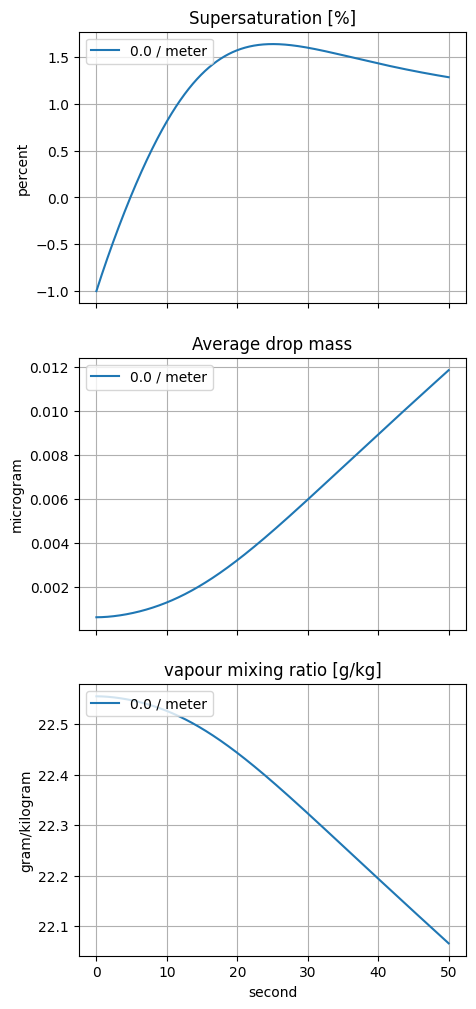

In [18]:
fig, axs = pyplot.subplots(3, 1, sharex=True, figsize=(5, 12))

for mu in solutions.keys():
    sys = systems[mu]
    sol = solutions[mu]
    t = zsteps[mu] / w

    axs[0].plot(t, sol.supersaturation, label=mu)
    axs[0].yaxis.set_units(si.percent)
    
    axs[1].plot(t, np.mean(sol.m, axis=0), label=mu)
    axs[1].yaxis.set_units(si.micrograms)

    axs[2].plot(t, sol.w_v, label=mu)
    axs[2].yaxis.set_units(si.grams / si.kilogram)
    break
    
for i in range(len(axs)):
    axs[i].legend(loc='upper left')
    axs[i].grid()
_ = axs[0].set_title('Supersaturation [%]')
_ = axs[1].set_title('Average drop mass')
_ = axs[2].set_title('vapour mixing ratio [g/kg]')